<a href="https://colab.research.google.com/github/saliniyan/dress_up_ai/blob/master/CV_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Clone* the *repository* containing the dataset into colab. This will allow access to the dataset inside this colab environment.

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 117.80 MiB | 10.05 MiB/s, done.
Updating files: 100% (4/4), done.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


The dataset is listed above: A *spreadsheet signnames.csv* and then *pickle files containing the train, test and validate* datasets.

Importing the Relevant Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import pickle
import pandas as pd
import random
import cv2

In [ ]:
np.random.seed(0)

*Unpickle* the Data to make it usable.

In [ ]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)



X_train , y_train = train_data['features'], train_data['labels']
X_val , y_val = val_data['features'], val_data['labels']
X_test , y_test = test_data['features'], test_data['labels']

We analyze the dataset to see how it looks like.

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


*shape* gives us the number of *images*, *dimensions in pixels* and* depth*.
The Images have a depth of 3 because they're in **RGB** format and thus the depth 3 for each color channel.

Next We Assert The dataset to see if its correct

In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "No. of Images is not equals to number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "No. of Images is not equals to number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "No. of Images is not equals to number of labels"

assert(X_train.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"

Showing the training set.
If the code seems cryptic you can check out the [pandas iterrows](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) documentation to see how it's used to allow you to iterate over DataFrame rows as (index, Series) pairs.  

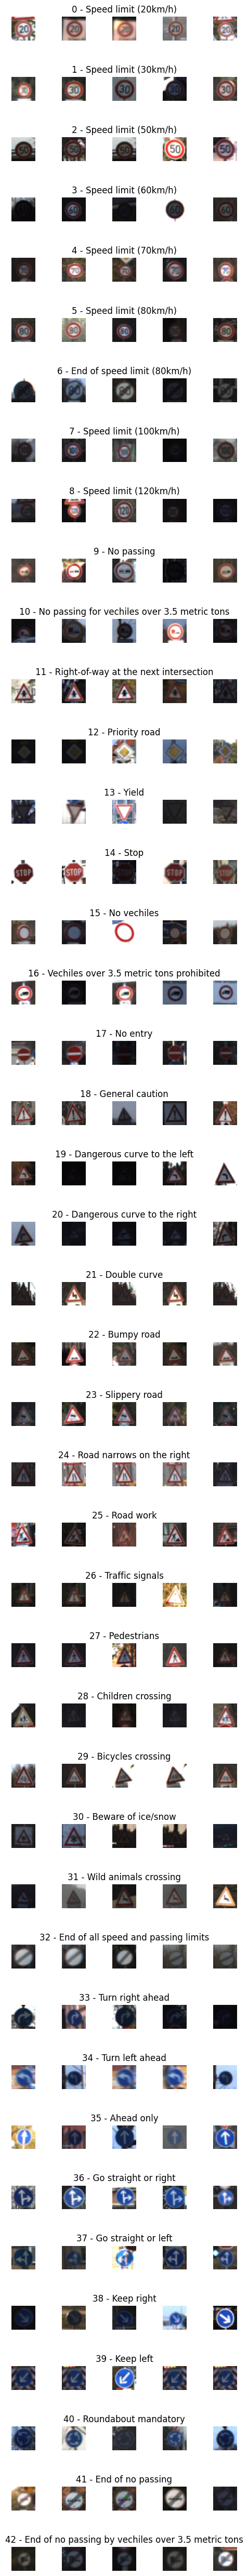

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
#print(data)

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))

plotting the distribution of the dataset.

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


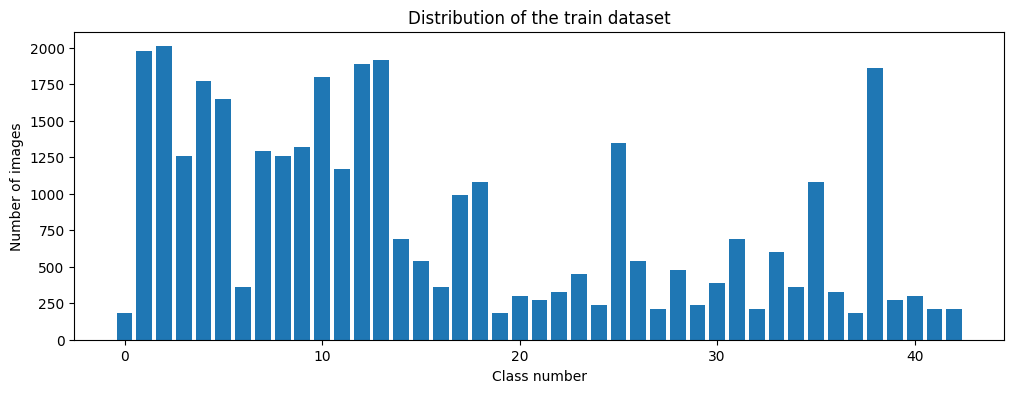

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
1


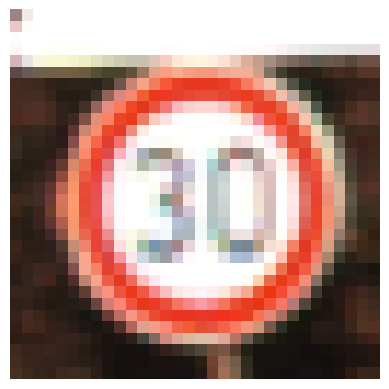

In [ ]:
plt.imshow(X_train[3000])
plt.axis("off")
print(X_train[3000].shape)
print(y_train[3000])

Now We'll Convert the image to grayscale i.e binary images with only two colors black or white.
**Why Convert to grayscale?** , Well for traffic signs *is color really important*? I don't think so, the important details are the **edges** and the **shapes** of the signs. Also We'll now need **fewer input parameters** for our neural network. Plus **less Computing Power**.

(32, 32)


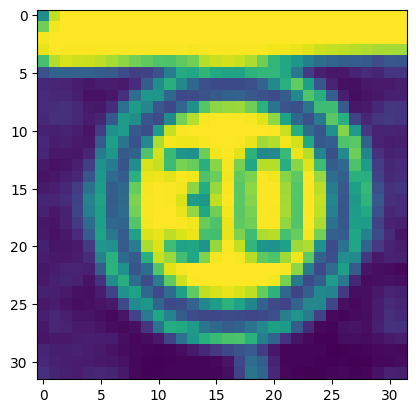

In [ ]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[3000])
plt.imshow(img)
#plt.axis("off")
print(img.shape)

Next We apply the Histogram Equalization technique to standardize lighting in all our images. Well because some images are more brighter and others very dim. Thus We need to give them a similar lighting effect. You can read about [Histogram Equalization Here](https://en.wikipedia.org/wiki/Histogram_equalization)

(32, 32)


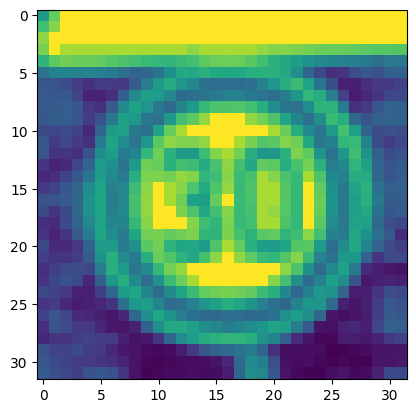

In [ ]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img


img = equalize(img)
plt.imshow(img)
print(img.shape)

Next We apply Preprocessing to all our images.

In [ ]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  #normalize the images, i.e. convert the pixel values to fit btwn 0 and 1
  img = img/255
  return img

Map Function Iterates through an entire array and perfoms a given operation. You can read about it  [here](https://www.journaldev.com/22960/python-map-function). So here we Preprocess all the images and update their variable storage.

In [ ]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

We Plot a random image from our train data to see that its correctly preprocessed

(34799, 32, 32)


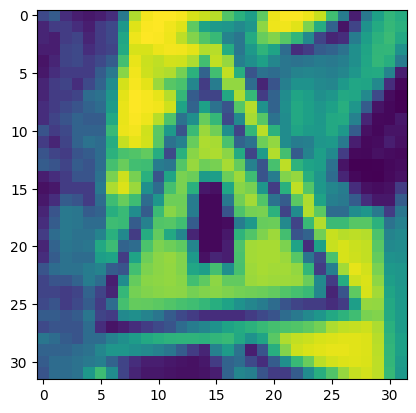

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
print(X_train.shape)

Next We add a depth to our images, that is required for our Convolutional Layer

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)


We generate variety datasets to better the model. Not *generate* but we show different angles and views of the same data set to the model for it to better identify the features.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)

(15, 32, 32, 1)


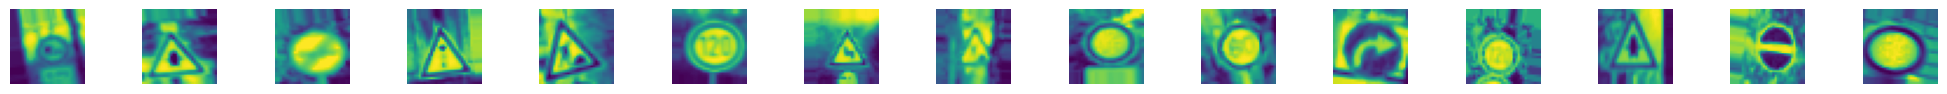

In [ ]:
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print(X_batch.shape)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


Next One Hot Encode the data labels. Here's an article that explains what is [one-hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f). Also refer to the Keras to_categorical documentation [here](https://keras.io/utils/)

In [ ]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

Next, It's time to define a leNet model. You may want to read about the LeNet model [here](https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Input

def pretrained_model(num_classes):
    base_model = MobileNetV2(input_shape=(32, 32, 3), weights='imagenet', include_top=False)

    model = Sequential()
    model.add(Input(shape=(32, 32, 1)))  # Grayscale input
    model.add(Conv2D(3, (1, 1), activation='relu'))  # Convert grayscale to RGB

    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Rebuild the model architecture
model = pretrained_model(num_classes=43)


# Print the summary to confirm the model is loaded correctly
print(model.summary())


<ipython-input-24-edbfc464f3ac>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(32, 32, 3), weights='imagenet', include_top=False)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 3)           │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1, 1, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 500)                 │         640,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,920,033 (11.14 MB)

 Trainable params: 2,885,921 (11.01 MB)

 Non-trainable params: 34,112 (133.25 KB)

None


Now to training and evaluating the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# EarlyStopping callback to stop if there's no improvement in validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ReduceLROnPlateau to decrease learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=len(X_train) // 50,
    epochs=7,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[early_stopping, reduce_lr]  # Adding the callbacks here
)



Epoch 1/7
695/695 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.8638 - loss: 0.4511 - val_accuracy: 0.6190 - val_loss: 1.9146 - learning_rate: 0.0010
Epoch 2/7
695/695 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8705 - loss: 0.4424 - val_accuracy: 0.4243 - val_loss: 4.0321 - learning_rate: 0.0010
Epoch 3/7
695/695 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.8746 - loss: 0.4082 - val_accuracy: 0.4381 - val_loss: 3.6500 - learning_rate: 0.0010
Epoch 4/7
695/695 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8609 - loss: 0.4527 - val_accuracy: 0.8113 - val_loss: 0.7437 - learning_rate: 5.0000e-04
Epoch 5/7
695/695 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9061 - loss: 0.3053 - val_accuracy: 0.9283 - val_loss: 0.2587 - learning_rate: 5.0000e-04
Epoch 6/7
695/695 ━━━━━━━━━━━━━━━━━━━━ 38s 26ms/step - accuracy: 0.9185 - loss: 0.2668 - val_accuracy: 0.8499 - val_loss: 0.5690 - learning_rate: 5.0000e-04
Epoch 7/7
695/695 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.922

Plotting and Visualizing how the network perfomed

Text(0.5, 0, 'epoch')

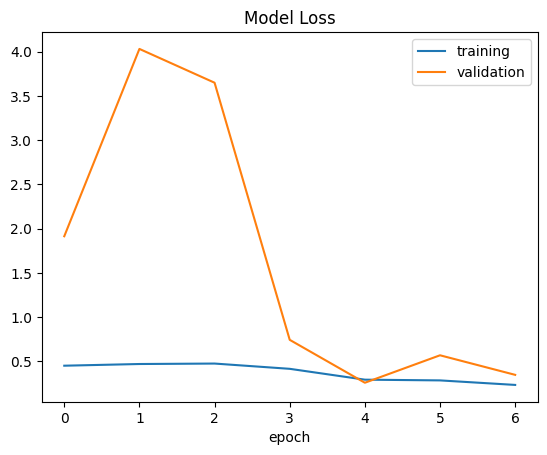

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Model Loss')
plt.xlabel('epoch')

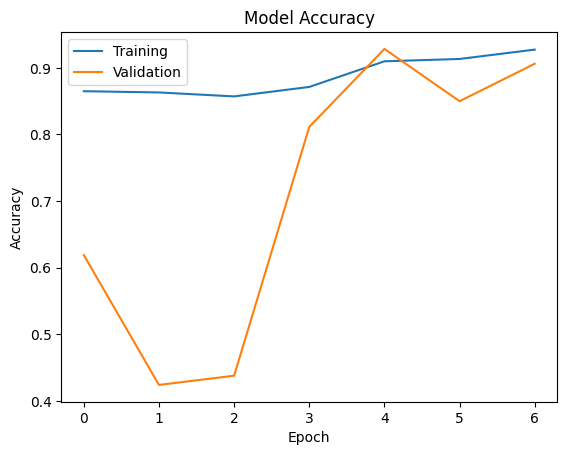

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


Evaluate the model

In [ ]:
score = model.evaluate(X_test, y_test , verbose = 0)
print("The Accuracy score is: ",score[1])

The Accuracy score is:  0.8769596219062805


Time to test the image on real images from the internet

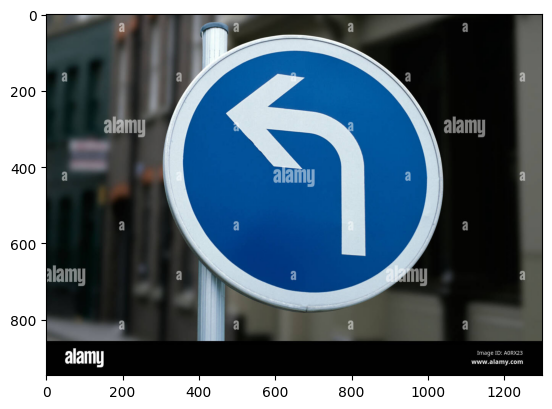

In [ ]:
#fetch image

import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


(32, 32)


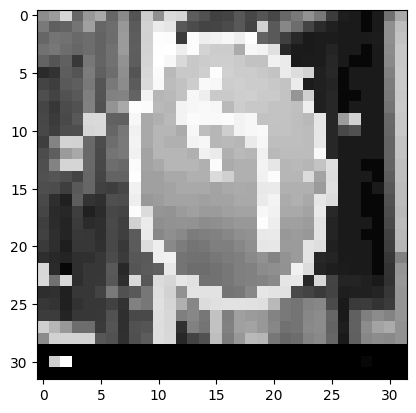

In [ ]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

In [ ]:
# Assuming 'img' is your test image that needs prediction and it's preprocessed correctly
prediction = model.predict(img)  # Predict the probabilities for each class
predicted_class = np.argmax(prediction, axis=1)  # Get the class with the highest probability

print("The Predicted sign: " + str(predicted_class))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The Predicted sign: [7]


Saving the model for later use

In [ ]:
from tensorflow.keras.models import load_model

# Save the model in Keras format
model.save('cv_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = model

# Print the summary to confirm it's loaded correctly
print(loaded_model.summary())


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 3)           │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1, 1, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 500)                 │         640,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,691,877 (33.16 MB)

 Trainable params: 2,885,921 (11.01 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 5,771,844 (22.02 MB)

None


The saved Model can be tested now

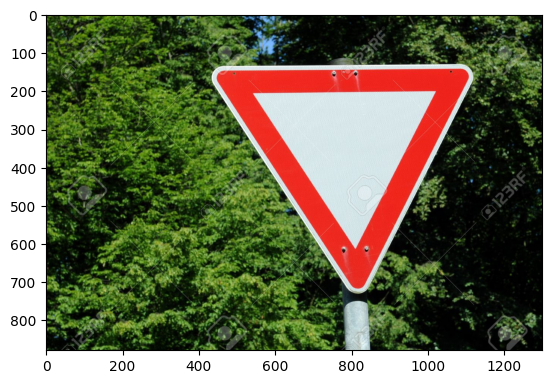

In [ ]:
#Testing the Saved Model

#fetch image

import requests
from PIL import Image
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


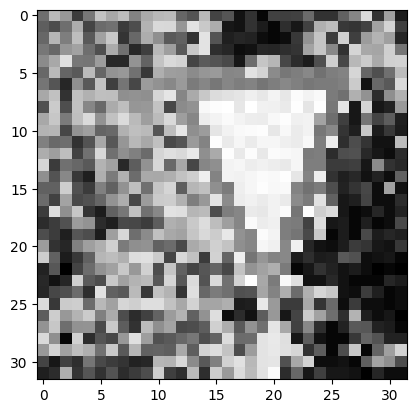

In [ ]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

In [ ]:
prediction = model.predict(img)
predicted_class = np.argmax(prediction, axis=1)

print("The Predicted sign: " + str(predicted_class))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The Predicted sign: [13]
